In [1]:
import lightgbm as lgb
import numpy as np
import pickle
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def save_pkl(file_dir, data):
    f = open(file_dir,"wb")
    pickle.dump(data, f, protocol=4)
    f.close()
    
def read_pkl(file_dir):
    f = open(file_dir,"rb")
    data = pickle.load(f)
    return data

def get_score(valid_y_exp, pred):
    return mean_absolute_error(pred, valid_y_exp)


Reading CSV file

In [3]:
df = pd.read_csv("Dataset/AAl_T_Weather_SkewFix_19des-22mar.csv")


Extracting our Timestamp column to week, year, month, day and hour columns, as Lightgbm can't handle Timestamp only numbers

In [4]:
df = df.rename(columns={"Recorded":"time","heat_index":"temperature","rh":"humidity","wdir":"wind_direction","wspd":"wind_speed",
                        'NO2': 'NO2_Concentration','NOx': 'NOx_Concentration',"O3":"O3_Concentration"})
df['time'] = pd.to_datetime(df['time'])
df.index = df['time']
df['time_week'] = df.index.map(lambda x: x.weekday)
df['time_year'] = df.index.map(lambda x: x.year)
df['time_month'] = df.index.map(lambda x: x.month)
df['time_day'] = df.index.map(lambda x: x.day)
df['time_hour'] = df.index.map(lambda x: x.hour)


Choosing Between Base or with weather data

In [7]:
#Airs = df[["NOx_Concentration","NO2_Concentration","O3_Concentration",'time_year', 'time_month', 'time_week', 'time_day', 
#           'time_hour',"temperature", "pressure", "humidity", "wind_direction", "wind_speed",]].copy()
Airs = df[["NO2_Concentration", "NOx_Concentration","O3_Concentration"
 #'time_year', 'time_month', 'time_week', 'time_day', 
          # 'time_hour',
         ]].copy()

season_dict={'April':"summer",
             'May':"summer",
             'June':"monsoon",
             'July':"monsoon",
             "August":"monsoon",
             'September':"pre-winter",
             'October':"pre-winter",
             'November':"winter",
             'December':"winter",
             'January':"winter",
             'February':"winter"}

def datetime_features(df):
  df['weekday']=df.timestamp.dt.day_name()
  df['month']=df.timestamp.dt.month_name()
  df['date']=df.timestamp.dt.strftime("%Y-%m-%d")
  df['time']=df.timestamp.dt.strftime("%H%M").astype("int")
  df["workinghrs"]=df["time"].apply(lambda x: 1 if x>600 & x<1800 else 0)
  df["season"]=df["month"].map(season_dict)

In [91]:
Airs = df.drop(columns=["wdir_cardinal","time","time_month", "time_day", "pressure"])


In [94]:
listing = []
for i in range(35519):
    tmp = Airs.iloc[i]
    tmp = np.hstack((tmp))
    listing.append(tmp)
        
    

In [95]:
NOx_list = Airs['NOx_Concentration'].values
NO2_list = Airs['NO2_Concentration'].values
O3_list = Airs['O3_Concentration'].values
Y_NOx_list = []
Y_NO2_list = []
Y_O3_list = []

X_extend_list = []
for i in range(1,35520):
    Y_NOx_list.append(NOx_list[i])
    Y_NO2_list.append(NO2_list[i])
    Y_O3_list.append(O3_list[i])

In [96]:
test_x = []
for i in range(35519,Airs.shape[0]-7):
    tmp = Airs.iloc[i]
    tmp = np.hstack((tmp))
    test_x.append(tmp)

In [97]:
Y_NOx_Test_list = []
Y_NO2_Test_list = []
Y_O3_Test_list = []
for i in range(35520,Airs.shape[0]-6):
    Y_NOx_Test_list.append(NOx_list[i])
    Y_NO2_Test_list.append(NO2_list[i])
    Y_O3_Test_list.append(O3_list[i])

In [98]:
Y_Test_NOx = np.vstack(Y_NOx_Test_list)
Y_Test_NO2 = np.vstack(Y_NO2_Test_list)
Y_Test_O3 = np.vstack(Y_O3_Test_list)
Y_Test_NOx = Y_Test_NOx.flatten()
Y_Test_NO2 = Y_Test_NO2.flatten()
Y_Test_O3 = Y_Test_O3.flatten()
X_Test = np.vstack(test_x)

In [54]:
X_Test.shape

(3839, 3)

In [99]:
Y_NOx = np.vstack(Y_NOx_list)
Y_NO2 = np.vstack(Y_NO2_list)
Y_O3 = np.vstack(Y_O3_list)
Y_NOx = Y_NOx.flatten()
Y_NO2 = Y_NO2.flatten()
Y_O3 = Y_O3.flatten()
X = np.vstack(listing)

In [56]:
print(X.shape,Y_NOx.shape,Y_NO2.shape)

(35519, 3) (35519,) (35519,)


In [14]:
#listfeature_name = ['NOx_Concentration','NO2_Concentration',"time_year", 'time_month','time_week','time_day','time_hour',]

In [142]:
listfeature_name = ['NOx_Concentration','NO2_Concentration',"O3_Concentration"]

In [16]:
listfeature_name = ['NOx_Concentration','NO2_Concentration',"O3_Concentration","time_year", 'time_month',          # feature 0-1# feature 2-6
                    'time_week','time_day','time_hour',
                    'temperature','pressure','humidity', 'wind_direction', 'wind_speed',#"NO2ratio","NOxratio"#"O3_Concentration",
                    ]

In [101]:
listfeature_name = ['NO2_Concentration','NOx_Concentration',"O3_Concentration","time_year",          # feature 0-1# feature 2-6
                    'time_week','time_hour',
                    'temperature','humidity', 'wind_direction', 'wind_speed',"NOx_min",#"NO2ratio","NOxratio"#"O3_Concentration",
                    ]

In [20]:
def train_test(model_param, train_X, test_X, train_Y, test_Y, save_dir):
    time_start = time.time()
    lgb_train = lgb.Dataset(train_X, train_Y)
    lgb_eval = lgb.Dataset(test_X, test_Y, reference=lgb_train)
    params = {
    'task': 'train',
    'verbosity': -1,
    'gpu_use_dp': True,
    'device_type': 'gpu',
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': {'mae'},
    'max_depth': model_param['depth'], #impact on model performance and train time
    'num_leaves': model_param['leaf'],
    'min_data_in_leaf': 20,
    'learning_rate': model_param['lr'],
    'num_threads':7
    # 'feature_fraction': 1, #can be used to speed up training and deal with overfitting
    # 'bagging_fraction': 0.8,
    # 'bagging_freq': 1,
    # 'bagging_seed': 3,
#     'min_sum_hessian_in_leaf': 100,
    }
    evaluation_results  = {}

    gbm = lgb.train(params,
                    train_set = lgb_train,
                    num_boost_round=model_param['tree'],
                    valid_sets=[lgb_train, lgb_eval],
                    valid_names=['Train', 'Valid'],
                    #categorical_feature=2,
                    #evals_result= evaluation_results,
                    #verbose_eval=500,
                    #early_stopping_rounds=3,
                    feature_name = listfeature_name,
                    callbacks=[lgb.early_stopping(stopping_rounds=3),lgb.log_evaluation(period=500),lgb.record_evaluation(eval_result=evaluation_results)]) 

    test_predict = gbm.predict(test_X)
    score = get_score(test_predict, test_Y)
    save_pkl(save_dir, gbm)
    print('running time: ', time.time() - time_start)

    lgb.plot_metric(evaluation_results)
    return score

In [102]:
train_X_NOx, test_X_NOx, train_Y_NOx, test_Y_NOx = train_test_split(X, Y_NOx, test_size=0.2,random_state=42)
print(train_X_NOx.shape, test_X_NOx.shape, train_Y_NOx.shape, test_Y_NOx.shape)

(28415, 11) (7104, 11) (28415,) (7104,)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[321]	Train's l1: 1.37917	Valid's l1: 1.41529
running time:  0.7529966831207275


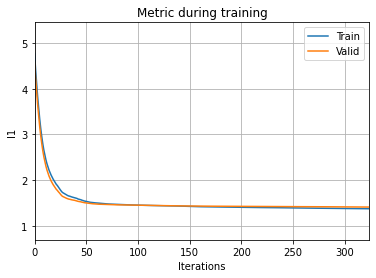

In [103]:
model_param={'lr': 0.1, 'depth': -1, 'tree': 3000, 'leaf': 10}
score = train_test(model_param, train_X_NOx, test_X_NOx, train_Y_NOx, test_Y_NOx, "LightGBM/lightgbm_T_W_NOx_10_1.model")

In [175]:
train_X_NO2, test_X_NO2, train_Y_NO2, test_Y_NO2 = train_test_split(X, Y_NO2, test_size=0.2,random_state=42)
print(train_X_NO2.shape, test_X_NO2.shape, train_Y_NO2.shape, test_Y_NO2.shape)

(28415, 10) (7104, 10) (28415,) (7104,)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[173]	Train's l1: 1.08055	Valid's l1: 1.11693
running time:  0.4530043601989746


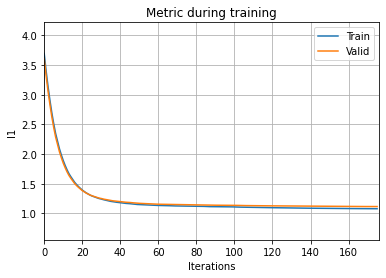

In [176]:
model_param={'lr': 0.1, 'depth': -1, 'tree': 3000, 'leaf': 10}
score = train_test(model_param, train_X_NO2, test_X_NO2, train_Y_NO2, test_Y_NO2, "LightGBM/lightgbm_T_W_NO2_10_1.model")

In [177]:
train_X_O3, test_X_O3, train_Y_O3, test_Y_O3 = train_test_split(X, Y_O3, test_size=0.2,random_state=42)
print(train_X_O3.shape, test_X_O3.shape, train_Y_O3.shape, test_Y_O3.shape)

(28415, 10) (7104, 10) (28415,) (7104,)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[125]	Train's l1: 2.24359	Valid's l1: 2.31737
running time:  0.38699913024902344


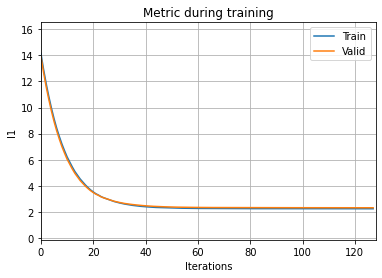

In [178]:
model_param={'lr': 0.1, 'depth': -1, 'tree': 3000, 'leaf': 10}
score = train_test(model_param, train_X_O3, test_X_O3, train_Y_O3, test_Y_O3, "LightGBM/lightgbm_T_W_O3_10_1.model")

In [179]:
gbmNO2 = read_pkl("LightGBM/lightgbm_T_W_NO2_10_1.model")
predict_NO2 = gbmNO2.predict(X_Test)
score_NO2 = get_score(predict_NO2, Y_Test_NO2)
score_NO2

1.089748016723843

In [104]:
gbmNOx = read_pkl("LightGBM/lightgbm_T_W_NOx_10_1.model")
predict_NOx = gbmNOx.predict(X_Test)
score_NOx = get_score(predict_NOx, Y_Test_NOx)
score_NOx

1.3311089481820282

In [88]:
gbmO3 = read_pkl("LightGBM/lightgbm_T_W_O3_10_1.model")
predict_O3 = gbmO3.predict(X_Test)
score_O3 = get_score(predict_O3, Y_Test_O3)
score_O3

ValueError: Found input variables with inconsistent numbers of samples: [3840, 3841]

In [86]:
predictionsDf = pd.DataFrame({"Pred_NO2":predict_NO2,"Pred_NOx":predict_NOx,"Pred_O3":predict_O3})
predictionsDf = predictionsDf.round(2)
predictionsDf.to_csv("LightGBM/AAl_T_Prediction.csv",index=False)

In [87]:
realDF = pd.DataFrame({"Real_NO2":Y_Test_NO2,"Real_NOx":Y_Test_NOx,"Real_O3":Y_Test_O3})
realDF.to_csv("LightGBM/AAl_T_Real.csv",index=False)

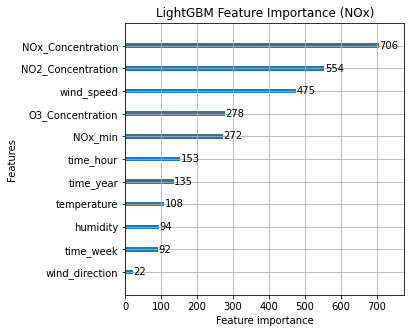

In [105]:
ax = lgb.plot_importance(gbmNOx,figsize=(5,5),importance_type="auto")
plt.title("LightGBM Feature Importance (NOx)")
plt.show()

In [87]:
plt.figure(num=None,dpi=70, figsize=(10, 6),facecolor='w', edgecolor='k')
plt.plot(predict_NO2[48:548], "-b",linewidth=3,  label='Predicted value')
plt.plot(Y_Test_NO2[48:548], "-r", label='Real values', )
plt.legend(loc="upper left")
plt.title('NO2 comparisons', x=0.45, y=0.8, loc='right')
plt.show()

NameError: name 'predict_NO2' is not defined

<Figure size 700x420 with 0 Axes>